# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

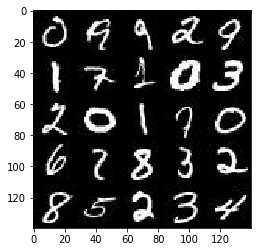

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

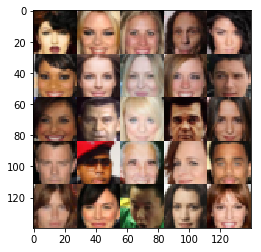

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [31]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name="lr")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [33]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)

    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real)))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))

    dis_loss = dis_loss_real + dis_loss_fake

    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = dis_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
            
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7301... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 1.9906... Generator Loss: 0.1864
Epoch 1/2... Discriminator Loss: 0.9798... Generator Loss: 0.6662
Epoch 1/2... Discriminator Loss: 1.6667... Generator Loss: 0.2712
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 0.4306
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.4242
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.3495
Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 0.4870
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.4527


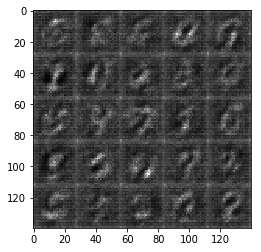

Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 0.5487
Epoch 1/2... Discriminator Loss: 1.2051... Generator Loss: 0.5048
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.5109
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 0.4430
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 0.7174
Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 0.4737
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 0.5449
Epoch 1/2... Discriminator Loss: 1.1747... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 0.5244


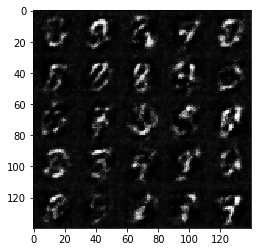

Epoch 1/2... Discriminator Loss: 1.1539... Generator Loss: 0.5017
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 0.9880... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 1.0103... Generator Loss: 0.5935
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 0.5538
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 0.7610
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 0.6043
Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 0.7021


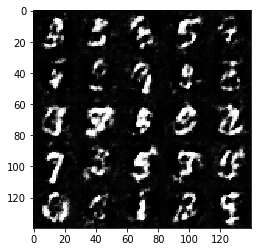

Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 1.5642
Epoch 1/2... Discriminator Loss: 0.7317... Generator Loss: 1.3504
Epoch 1/2... Discriminator Loss: 0.7275... Generator Loss: 1.6902
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 1.8535
Epoch 1/2... Discriminator Loss: 0.8068... Generator Loss: 1.8656
Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 1.4873
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 2.3171
Epoch 1/2... Discriminator Loss: 0.6999... Generator Loss: 0.9552
Epoch 1/2... Discriminator Loss: 0.9044... Generator Loss: 0.6467
Epoch 1/2... Discriminator Loss: 0.7742... Generator Loss: 0.8482


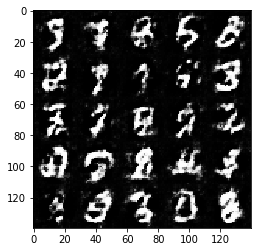

Epoch 1/2... Discriminator Loss: 0.7379... Generator Loss: 0.8450
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 2.6189
Epoch 1/2... Discriminator Loss: 0.5863... Generator Loss: 1.5130
Epoch 1/2... Discriminator Loss: 0.6876... Generator Loss: 2.2714
Epoch 1/2... Discriminator Loss: 0.6042... Generator Loss: 1.1429
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 2.2605
Epoch 1/2... Discriminator Loss: 0.5976... Generator Loss: 1.5387
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 0.8237... Generator Loss: 0.7599
Epoch 1/2... Discriminator Loss: 0.9853... Generator Loss: 0.6350


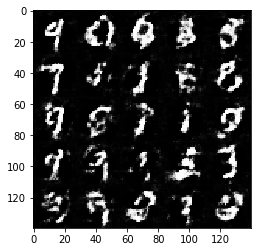

Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 0.9566... Generator Loss: 0.6685
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 0.6405
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 0.4952
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 1.0393
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 1.1055... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 1.3244... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 0.5714


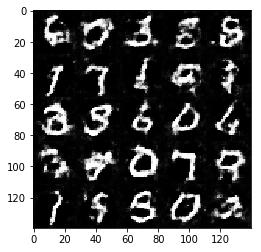

Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 0.5220
Epoch 2/2... Discriminator Loss: 1.0656... Generator Loss: 0.5668
Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 0.9703... Generator Loss: 1.6614
Epoch 2/2... Discriminator Loss: 0.7820... Generator Loss: 1.5526
Epoch 2/2... Discriminator Loss: 1.0944... Generator Loss: 2.0331
Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.8974
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.5571
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 2.0815


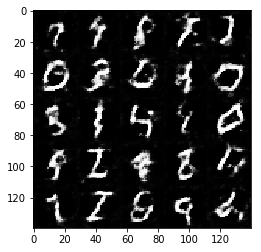

Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 1.7689
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.4541
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 1.7305
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.3133
Epoch 2/2... Discriminator Loss: 0.7972... Generator Loss: 1.5092
Epoch 2/2... Discriminator Loss: 0.8406... Generator Loss: 1.1411
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 2.0929
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 0.9578
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.4524
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 0.9554


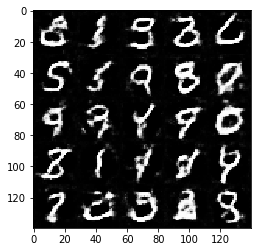

Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 0.4868
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 0.5428
Epoch 2/2... Discriminator Loss: 0.8622... Generator Loss: 1.3395
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 1.6012
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 1.7014
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 1.6987
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.4142
Epoch 2/2... Discriminator Loss: 0.8853... Generator Loss: 1.4697
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.3642
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.7614


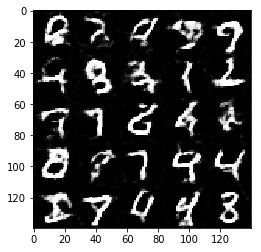

Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 0.3713
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 0.9368
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 1.3352
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 1.6925
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 0.9583... Generator Loss: 1.7790
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 0.5975
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.6066


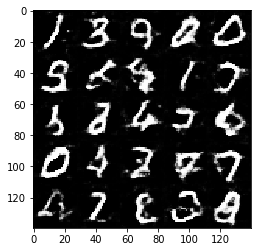

Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 1.3681
Epoch 2/2... Discriminator Loss: 0.7394... Generator Loss: 1.3874
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 0.8677... Generator Loss: 1.5761
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 0.9003... Generator Loss: 1.5440
Epoch 2/2... Discriminator Loss: 0.7368... Generator Loss: 1.4655
Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 0.8701... Generator Loss: 0.7243
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 1.6026


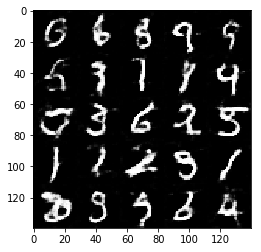

Epoch 2/2... Discriminator Loss: 0.8140... Generator Loss: 1.6546
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 0.5964
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.7738
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 1.8954
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 1.4777
Epoch 2/2... Discriminator Loss: 0.8531... Generator Loss: 0.7793
Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 0.8566... Generator Loss: 0.7465


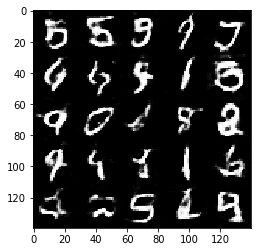

In [41]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 28.6116
Epoch 1/1... Discriminator Loss: 0.0179... Generator Loss: 8.7490
Epoch 1/1... Discriminator Loss: 0.1163... Generator Loss: 5.0113
Epoch 1/1... Discriminator Loss: 4.2540... Generator Loss: 0.0846
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 2.0915
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 0.9156
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 2.1579
Epoch 1/1... Discriminator Loss: 3.7114... Generator Loss: 13.6807
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 0.8720
Epoch 1/1... Discriminator Loss: 0.2021... Generator Loss: 3.5218


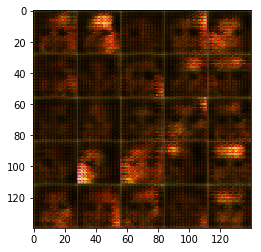

Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 1.7344... Generator Loss: 3.2362
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 0.9940
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 5.1660... Generator Loss: 5.3657
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7153


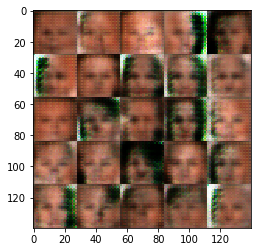

Epoch 1/1... Discriminator Loss: 1.8637... Generator Loss: 0.2749
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 1.5932
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 1.3816
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 1.6103
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.2031


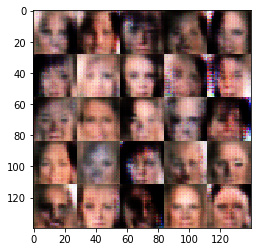

Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 2.1620... Generator Loss: 0.1660
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.8869... Generator Loss: 0.2211
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 1.3510


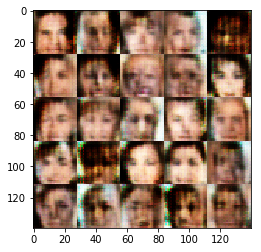

Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.5956... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7205


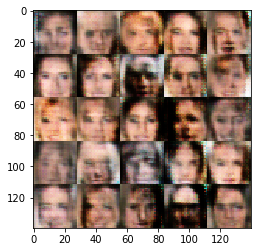

Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.6168


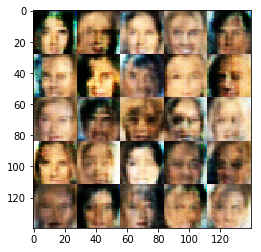

Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 1.0054
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6364


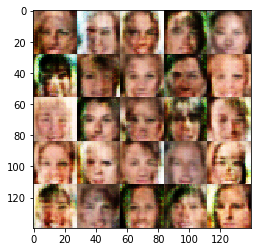

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.7125... Generator Loss: 0.2737
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 1.5619
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.8632


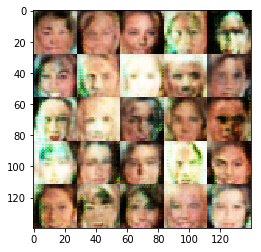

Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.7825
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6839


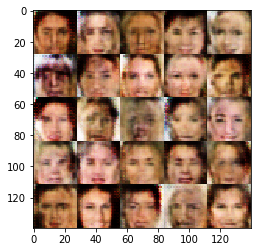

Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.2347
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.4346
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.6811


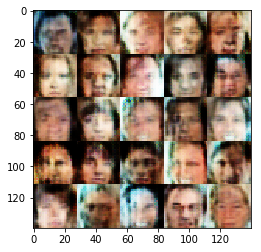

Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.6748
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.6875


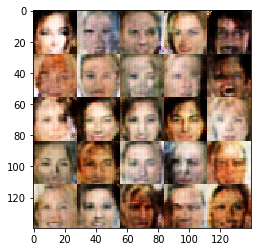

Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 1.0829
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 1.5030


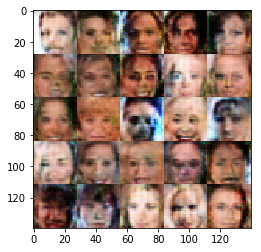

Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.4012
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7302


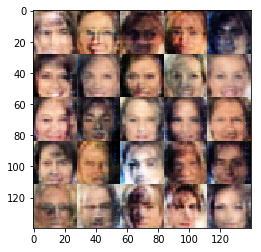

Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 0.3443
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.9523


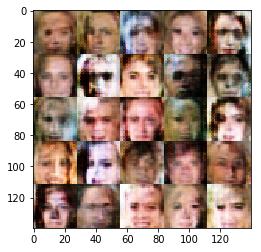

Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.2100
Epoch 1/1... Discriminator Loss: 1.9022... Generator Loss: 0.2241
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.6992


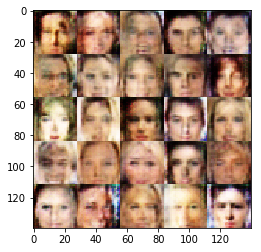

Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 1.0374


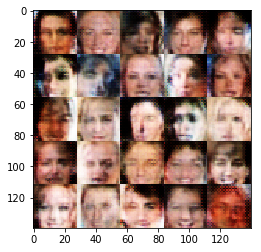

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5978
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.5636


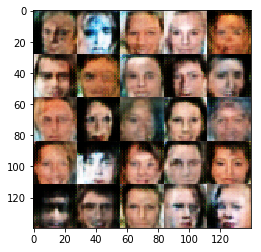

Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 1.0727


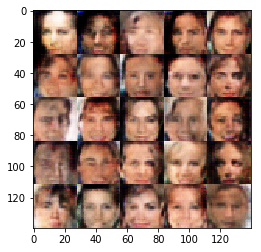

Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.6680


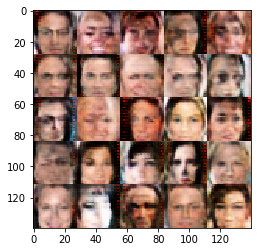

Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.9093
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7109


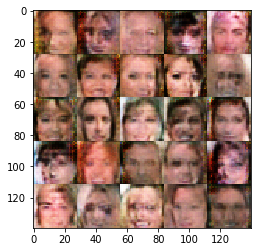

Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.8315


In [42]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.